# Seam Carving

The material presented here is inspired from:

Tài liệu sử dụng được tham khảo từ đây:
- paper on seam carving: http://graphics.cs.cmu.edu/courses/15-463/2007_fall/hw/proj2/imret.pdf
- tutorial: http://cs.brown.edu/courses/cs129/results/proj3/taox
- tutorial: http://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/f07/proj2/www/wwedler/

Don't hesitate to check these links if you have any doubt on the seam carving process.

Hãy xem các tài liệu bên trên nếu bạn chưa hiểu rõ về phương pháp seam carving.

The whole seam carving process was covered in [lecture 8](http://vision.stanford.edu/teaching/cs131_fall1718/files/08_seam_carving.pdf), please refer to the slides for more details to the different concepts introduced here.

Toàn bộ quá trình seam carving được trình bày trong lecture_8. Xem thêm các slides bài giảng.

In [1]:
# Setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import color

from time import time
from IPython.display import HTML



%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

print("Bành Phước Trung B1509899")
print("Phan Thế Bình B1400479")



Bành Phước Trung B1509899
Phan Thế Bình B1400479


## Image Reducing using Seam Carving
## Giảm kích thước ảnh bằng phương pháp Seam Carving

Seam carving is an algorithm for content-aware image resizing.
To understand all the concepts in this homework, make sure to read again the slides from lecture 8:

Seam carving là một giải thuật thay đổi kích thước ảnh mà không làm biến dạng các đối tượng quan trọng trong ảnh.
Để hiểu tất cả các khái niệm trong bài tập này, bạn phải đọc lại các slides bài giảng 8.

http://vision.stanford.edu/teaching/cs131_fall1718/files/08_seam_carving.pdf

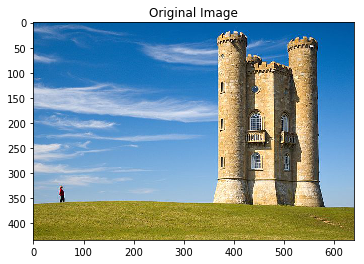

In [2]:
from skimage import io, util

# Load image
img = io.imread('imgs/broadway_tower.jpg')
img = util.img_as_float(img)

plt.title('Original Image')
plt.imshow(img)
plt.show()

### Energy function (5 points)
### Hàm năng lượng
We will now implemented the `energy_function` to compute the energy of the image.

Ta sẽ cài đặt hàm `energy_function` để tính năng lượng của ảnh.

The energy at each pixel is the sum of:

Năng lượng tại mỗi điểm là tổng của:
- absolute value of the gradient in the $x$ direction
- giá trị tuyệt đối của gradient theo hướng $x$ và
- absolute value of the gradient in the $y$ direction
- giá trị tuyệt đối của gradient theo hướng $y$

The function should take around 0.01 to 0.1 seconds to compute.

Hàm này chạy khoảng từ 0.01 đến 0.1 giây.

In [3]:
from seam_carving import energy_function

test_img = np.array([[1.0, 2.0, 1.5],
                     [3.0, 1.0, 2.0],
                     [4.0, 0.5, 3.0]])
test_img = np.stack([test_img] * 3, axis=2)
assert test_img.shape == (3, 3, 3)

# Compute energy function
test_energy = energy_function(test_img)

solution_energy = np.array([[3.0, 1.25,  1.0],
                            [3.5, 1.25, 1.75],
                            [4.5,  1.0,  3.5]])

print("Image (channel 0):")
print(test_img[:, :, 0])

print("Energy:")
print(test_energy)
print("Solution energy:")
print(solution_energy)

assert np.allclose(test_energy, solution_energy)

Image (channel 0):
[[1.  2.  1.5]
 [3.  1.  2. ]
 [4.  0.5 3. ]]
Energy:
[[3.   1.25 1.  ]
 [3.5  1.25 1.75]
 [4.5  1.   3.5 ]]
Solution energy:
[[3.   1.25 1.  ]
 [3.5  1.25 1.75]
 [4.5  1.   3.5 ]]


Computing energy function: 0.008106 seconds.


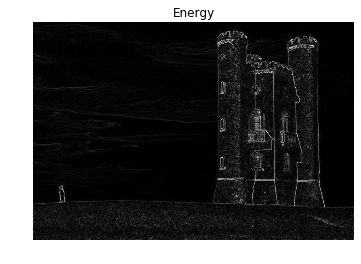

In [4]:
# Compute energy function
start = time()
energy = energy_function(img)
end = time()

print("Computing energy function: %f seconds." % (end - start))

plt.title('Energy')
plt.axis('off')
plt.imshow(energy)
plt.show()

### Compute cost (10 points)

Now implement the function `compute_cost`.

Tiếp đến cài đặt hàm `compute_cost`.

Starting from the energy map, we'll go from the first row of the image to the bottom and compute the minimal cost at each pixel.
We'll use dynamic programming to compute the cost line by line starting from the first row.

Từ mảng năng lượng, ta sẽ đi từ hàng đầu tiên đến hàng cuối cùng để tính chi phí thấp nhất tại từng điểm: M(i,j)
Sử dụng quy hoạch động để tính.

The function should take around 0.05 seconds to complete.

Hàm này chạy khoảng 0.05 giây.

In [5]:
from seam_carving import compute_cost

# Let's first test with a small example

test_energy = np.array([[1.0, 2.0, 1.5],
                        [3.0, 1.0, 2.0],
                        [4.0, 0.5, 3.0]])

solution_cost = np.array([[1.0, 2.0, 1.5],
                          [4.0, 2.0, 3.5],
                          [6.0, 2.5, 5.0]])

solution_paths = np.array([[ 0,  0,  0],
                           [ 0, -1,  0],
                           [ 1,  0, -1]])

# Vertical Cost Map
vcost, vpaths = compute_cost(_, test_energy, axis=1)  # don't need the first argument for compute_cost

print("Energy:")
print(test_energy)

print("Cost:")
print(vcost)
print("Solution cost:")
print(solution_cost)

print("Paths:")
print(vpaths)
print("Solution paths:")
print(solution_paths)

Energy:
[[1.  2.  1.5]
 [3.  1.  2. ]
 [4.  0.5 3. ]]
Cost:
[[1.  2.  1.5]
 [4.  2.  3.5]
 [6.  2.5 5. ]]
Solution cost:
[[1.  2.  1.5]
 [4.  2.  3.5]
 [6.  2.5 5. ]]
Paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 1  0 -1]]
Solution paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 1  0 -1]]


Computing vertical cost map: 0.067548 seconds.


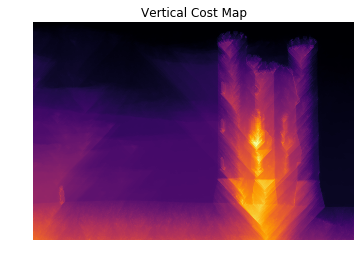

In [6]:
# Vertical Cost Map
start = time()
vcost, _ = compute_cost(_, energy, axis=1)  # don't need the first argument for compute_cost
end = time()

print("Computing vertical cost map: %f seconds." % (end - start))

plt.title('Vertical Cost Map')
plt.axis('off')
plt.imshow(vcost, cmap='inferno')
plt.show()

Computing horizontal cost map: 0.083064 seconds.


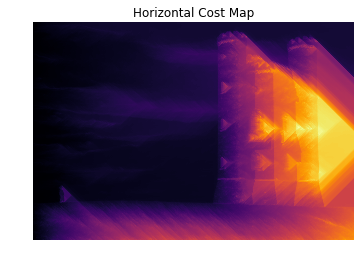

In [7]:
# Horizontal Cost Map
start = time()
hcost, _ = compute_cost(_, energy, axis=0)
end = time()

print("Computing horizontal cost map: %f seconds." % (end - start))

plt.title('Horizontal Cost Map')
plt.axis('off')
plt.imshow(hcost, cmap='inferno')
plt.show()

## Finding optimal seams
## Tìm seam tối ưu

Using the cost maps we found above, we can determine the seam with the lowest energy in the image.  
We can then remove this optimal seam, and repeat the process until we obtain a desired width.

Sử dụng mảng chi phí (M(i,j)), ta sẽ xác định ô có năng lượng thấp nhất trong ảnh.
Loại bỏ seam này, và lặp lại quá trình này cho đến khi đạt được kích thước mong muốn.

### Backtrack seam (5 points)
### Quy lui tìm seam

Implement function `backtrack_seam`.

Cài đặt hàm `backtrack_seam`.

In [8]:
from seam_carving import backtrack_seam

# Let's first test with a small example
cost = np.array([[1.0, 2.0, 1.5],
                 [4.0, 2.0, 3.5],
                 [6.0, 2.5, 5.0]])

paths = np.array([[ 0,  0,  0],
                  [ 0, -1,  0],
                  [ 1,  0, -1]])


# Vertical Backtracking

end = np.argmin(cost[-1])
seam_energy = cost[-1, end]
seam = backtrack_seam(vpaths, end)

print('Seam Energy:', seam_energy)
print('Seam:', seam)

assert seam_energy == 2.5
assert np.allclose(seam, [0, 1, 1])

Seam Energy: 2.5
Seam: [0 1 1]


Backtracking optimal seam: 0.000418 seconds.
Seam Energy: 2.443948431372549


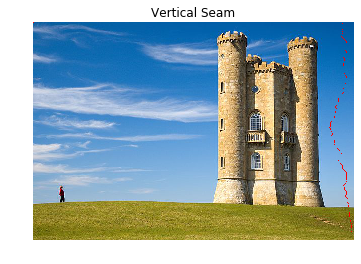

In [14]:
vcost, vpaths = compute_cost(img, energy)

# Vertical Backtracking
start = time()
end = np.argmin(vcost[-1])
seam_energy = vcost[-1, end]
seam = backtrack_seam(vpaths, end)
# print (end)
# print (vpaths )
# print (seam.shape)
end = time()

print("Backtracking optimal seam: %f seconds." % (end - start))
print('Seam Energy:', seam_energy)

# Visualize seam
vseam = np.copy(img)
for row in range(vseam.shape[0]):
    vseam[row, seam[row], :] = np.array([1.0, 0, 0])

plt.title('Vertical Seam')
plt.axis('off')
plt.imshow(vseam)
plt.show()

In the image above, the optimal vertical seam (minimal cost) goes through the portion of sky without any cloud, which yields the lowest energy.

Trong ảnh trên, seam dọc tối ưu (chi phí thấp nhất) đi từ vùng trời không có mây, có năng lượng thấp nhất.
---

### Reduce (25 points)
### Thu nhỏ

We can now use the function `backtrack` and `remove_seam` iteratively to reduce the size of the image through **seam carving**.

Sử dụng 2 hàm `backtrack` và `remove_seam` để thu nhỏ kích thước ảnh.

Each reduce can take around 10 seconds to compute, depending on your implementation.
If it's too long, try to vectorize your code in `compute_cost` to only use one loop.

Mỗi lần thu nhỏ mất khoảng 10 giây, tuỳ thuộc vào cách cài đặt của bạn.
Nếu thấy nó lâu quá, hãy thử sử dụng các phép toán trên ma trận và vector trong hàm `compute_cost` để chỉ sử dụng 1 vòng lặp thôi.

In [9]:
from seam_carving import reduce

# Let's first test with a small example
test_img = np.arange(9, dtype=np.float64).reshape((3, 3))
test_img = np.stack([test_img, test_img, test_img], axis=2)
assert test_img.shape == (3, 3, 3)

cost = np.array([[1.0, 2.0, 1.5],
                 [4.0, 2.0, 3.5],
                 [6.0, 2.5, 5.0]])

paths = np.array([[ 0,  0,  0],
                  [ 0, -1,  0],
                  [ 1,  0, -1]])

# Reduce image width
W_new = 2

# We force the cost and paths to our values
out = reduce(test_img, W_new, cfunc=lambda x, y:(cost, paths) )

print("Original image (channel 0):")
print(test_img[:, :, 0])
print("Reduced image (channel 0): we see that seam [0, 4, 7] is removed")
print(out[:, :, 0])

assert np.allclose(out[:, :, 0], np.array([[1, 2], [3, 5], [6, 8]]))

Original image (channel 0):
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
Reduced image (channel 0): we see that seam [0, 4, 7] is removed
[[1. 2.]
 [3. 5.]
 [6. 8.]]


Reducing width from 640 to 400: 13.561052 seconds.


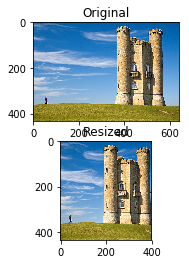

In [10]:
# Reduce image width
H, W, _ = img.shape
W_new = 400

start = time()
out = reduce(img, W_new)
end = time()

print("Reducing width from %d to %d: %f seconds." % (W, W_new, end - start))

plt.subplot(2, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

We observe that resizing from width 640 to width 400 conserves almost all the important part of the image (the person and the castle), where a standard resizing would have compressed everything.

Ta quan sát thấy rằng việc thu nhỏ chiều rộng từ 640 còn lại 400 bảo toàn gần như toàn bộ các vùng quan trọng trên ảnh (em bé và lâu đài), trong khi việc thay đổi kích thước bình thường làm mọi thứ bị nén lại (ốm hơn :-))

All the vertical seams removed avoid the person and the castle.

Tất cả các seam dọc bị loại bỏ đều tránh em bé và lâu đài.

Reducing height from 434 to 300: 11.268312 seconds.


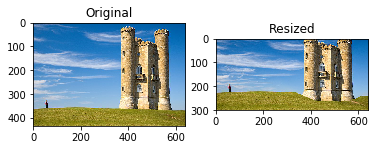

In [10]:
# Reduce image height
H, W, _ = img.shape
H_new = 300

start = time()
out = reduce(img, H_new, axis=0)
end = time()

print("Reducing height from %d to %d: %f seconds." % (H, H_new, end - start))

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

For reducing the height, we observe that the result does not look as nice.

Với việc thu nhỏ chiều cao, ta quan sát thấy rằng kết quả sẽ không đẹp như mong muốn.

The issue here is that the castle is on all the height of the image, so most horizontal seams will go through it.  
Interestingly, we observe that most of the grass is not removed. This is because the grass has small variation between neighboring pixels (in a kind of noisy pattern) that make it high energy.  
The seams removed go through the sky on the left, go under the castle to remove some grass and then back up in the low energy blue sky.

Vấn đề ở đây là lâu đài chiếm hết chiều cao của bức ảnh, vì thế hầu hết các seam ngang đều đi ngang qua nó. Thú vị là hầu hết bãi cỏ không bị loại bỏ. Đó là vì gradient trên bãi cỏ vẫn lớn => năng lượng lớn.
Các seam bị loại bỏ đều đi qua chỗ bầu trời bên trái, xuống dưới chân lâu đài và đi ngược lên vùng bầu trời có năng lượng thấp.

## Image Enlarging
## Phóng to

### Enlarge naive (10 points)
### Phóng tó đơn giản
We now want to tackle the reverse problem of enlarging an image.  
One naive way to approach the problem would be to duplicate the optimal seam iteratively until we reach the desired size.

Cách đơn giản để phóng to là lặp đi lặp lại quá trình nhân đôi seam cho đến khi đạt được kích thước mong muốn.

In [13]:
from seam_carving import enlarge_naive

# Let's first test with a small example
test_img = np.arange(9, dtype=np.float64).reshape((3, 3))
test_img = np.stack([test_img, test_img, test_img], axis=2)
assert test_img.shape == (3, 3, 3)

cost = np.array([[1.0, 2.0, 1.5],
                 [4.0, 2.0, 3.5],
                 [6.0, 2.5, 5.0]])

paths = np.array([[ 0,  0,  0],
                  [ 0, -1,  0],
                  [ 1,  0, -1]])

# Increase image width
W_new = 4

# We force the cost and paths to our values
out = enlarge_naive(test_img, W_new, cfunc=lambda x, y: (cost, paths))

print("Original image (channel 0):")
print(test_img[:, :, 0])
print("Enlarged image (channel 0): we see that seam [0, 4, 7] is duplicated")
print(out[:, :, 0])

assert np.allclose(out[:, :, 0], np.array([[0, 0, 1, 2], [3, 4, 4, 5], [6, 7, 7, 8]]))

Original image (channel 0):
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
Enlarged image (channel 0): we see that seam [0, 4, 7] is duplicated
[[0. 0. 1. 2.]
 [3. 4. 4. 5.]
 [6. 7. 7. 8.]]


Enlarging(naive) height from 640 to 800: 11.070703 seconds.


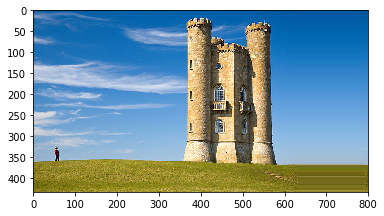

In [14]:
W_new = 800

# This is a naive implementation of image enlarging
# which iteratively computes energy function, finds optimal seam
# and duplicates it.
# This process will a stretching artifact by choosing the same seam
start = time()
enlarged = enlarge_naive(img, W_new)
end = time()

# Can take around 20 seconds
print("Enlarging(naive) height from %d to %d: %f seconds." \
      % (W, W_new, end - start))

plt.imshow(enlarged)
plt.show()

The issue with `enlarge_naive` is that the same seam will be selected again and again, so this low energy seam will be the only to be duplicated.

Vấn đề với phương pháp phóng to đơn giản `enlarge_naive` là chỉ có 1 seam duy nhất được chọn trong tất cả các vòng lặp và chỉ có nó được nhân đôi.

Another way to get k different seams is to apply the process we used in function `reduce`, and keeping track of the seams we delete progressively.
The function `find_seams(image, k)` will find the top k seams for removal iteratively.

Một cách khác để lấy k seam khác nhau là áp dụng quá trình ta đã sử dụng trong hàm `reduce`, và lưu lại các seams mà ta muốn xoá. Sau đó nhân đôi tất cả các seam này.
Hàm `find_seams(image, k)` sẽ tìm k seam đầu tiên để xoá bỏ.

The inner workings of the function are a bit tricky so we've implemented it for you, but you should go into the code and understand how it works.  
This should also help you for the implementation of `enlarge`.

Cách thức hoạt động của hàm này tương đối phức tạp nên người ta đã cài đặt giúp bạn, tuy nhiên bạn cũng cần phải xem chương trình nguồn để hiểu cách thức hoạt động của nó.
Điều này sẽ giúp các bạn cài được hàm `enlarge`.


Finding 160 seams: 10.415524 seconds.


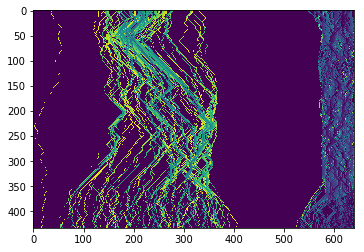

In [19]:
from seam_carving import find_seams

# Alternatively, find k seams for removal and duplicate them.
start = time()
seams = find_seams(img, W_new - W)
# seams = find_seams(img, 50)
end = time()

# Can take around 10 seconds
print("Finding %d seams: %f seconds." % (W_new - W, end - start))

plt.imshow(seams, cmap='viridis')
plt.show()

### Enlarge (25 points)

We can see that all the seams found are different, and they avoid the castle and the person.

One issue we can mention is that we cannot enlarge more than we can reduce. Because of our process, the maximum enlargement is the width of the image `W` because we first need to find `W` different seams in the image.

One effect we can see on this image is that the blue sky at the right of the castle can only be enlarged x2. The concentration of seams in this area is very strong.  
We can also note that the seams at the right of the castle have a blue color, which means they have low value and were removed in priority in the seam selection process.

Ta có thể thấy rằng tất cả seam tìm thấy đều khác nhau, và nó cũng tránh không đi xuyên qua lâu đài và em bé.

Một vấn đề ta phải quan tâm là ta không thể phóng ta nhiều hơn những thứ mà ta có thể thu nhỏ. Vì bản chất của quá trình xử lý của chúng ta, phần phóng to nhiều nhất là chiều rộng của ảnh `W` vì ta cần phải tìm `W` seam khác nhau.

Một hiệu ứng mà ta có thể thấy trên ảnhn ày là bầu trời xanh bên góc phải của lâu đài có thể phóng to 2 lần. Gần như tất cả các seam đều tập trung ở chỗ này.
Ta cũng có thể chú ý thấy rằng các seam bên phía phải của lâu đài có màu xanh, điều này có nghĩa là chúng có giá trị thấp và bị loại bỏ trước trong quá trình xử lý.

In [29]:
from seam_carving import enlarge

# Let's first test with a small example
test_img = np.array([[0.0, 1.0, 3.0],
                     [0.0, 1.0, 3.0],
                     [0.0, 1.0, 3.0]])
#test_img = np.arange(9, dtype=np.float64).reshape((3, 3))
test_img = np.stack([test_img, test_img, test_img], axis=2)
assert test_img.shape == (3, 3, 3)

# Increase image width
W_new = 5

out_naive = enlarge_naive(test_img, W_new)
out = enlarge(test_img, W_new)

print("Original image (channel 0):")
print(test_img[:, :, 0])
print("Enlarged naive image (channel 0): first seam is duplicated twice.")
print(out_naive[:, :, 0])
print("Enlarged image (channel 0): first and second seam are each duplicated once.")
print(out[:, :, 0])

assert np.allclose(out[:, :, 0], np.array([[0, 0, 1, 1, 3], [0, 0, 1, 1, 3], [0, 0, 1, 1, 3]]))

Original image (channel 0):
[[0. 1. 3.]
 [0. 1. 3.]
 [0. 1. 3.]]
Enlarged naive image (channel 0): first seam is duplicated twice.
[[0. 0. 0. 1. 3.]
 [0. 0. 0. 1. 3.]
 [0. 0. 0. 1. 3.]]
Enlarged image (channel 0): first and second seam are each duplicated once.
[[0. 0. 1. 1. 3.]
 [0. 0. 1. 1. 3.]
 [0. 0. 1. 1. 3.]]


Enlarging width from 640 to 800: 14.056678 seconds.


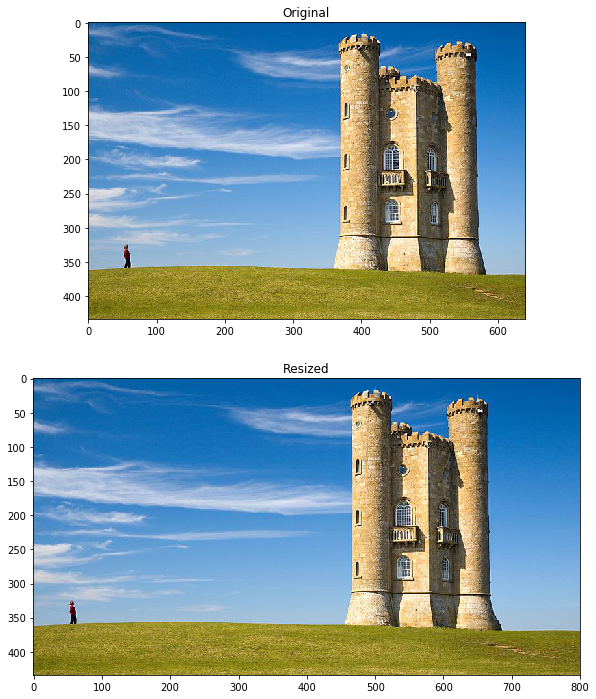

In [30]:
W_new = 800

start = time()
out = enlarge(img, W_new)
end = time()

# Can take around 20 seconds
print("Enlarging width from %d to %d: %f seconds." \
      % (W, W_new, end - start))

plt.subplot(2, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

Finding 160 seams: 13.246605 seconds.


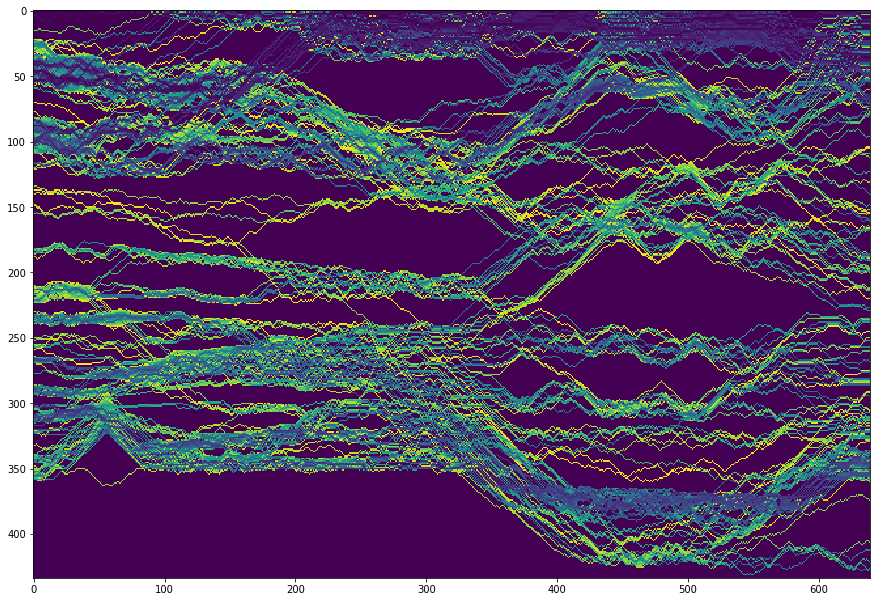

In [31]:
# Map of the seams for horizontal seams.
start = time()
seams = find_seams(img, W_new - W, axis=0)
end = time()

# Can take around 15 seconds
print("Finding %d seams: %f seconds." % (W_new - W, end - start))

plt.imshow(seams, cmap='viridis')
plt.show()

Enlarging height from 434 to 600: 18.946053 seconds.


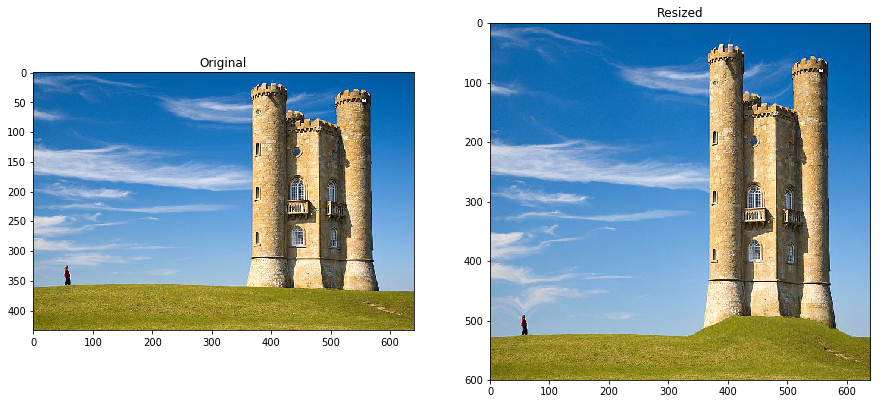

In [31]:
H_new = 600

start = time()
out = enlarge(img, H_new, axis=0)
end = time()

# Can take around 20 seconds
print("Enlarging height from %d to %d: %f seconds." \
      % (H, H_new, end - start))

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

As you can see in the example above, the sky above the castle has doubled in size, the grass below has doubled in size but we still can't reach a height of 600.  
The algorithm then needs to enlarge the castle itself, while trying to avoid enlarging the windows for instance.

Như bạn thấy trong ví dụ trên, bầu trời phía trên lâu đài đã bị nhân đôi, bãi cỏ bên dưới cũng vậy nhưng ta vẫn chưa đạt được chiều cao 600.
Tiếp theo đó, giải thuật cần phóng to lâu đài, trong khi tránh phóng ta các cửa sổ.

## Other experiments on the image

Feel free to experiment more on this image, try different sizes to enlarge or reduce, or check what seams are chosen...

Reducing by a 2x factor often leads to weird patterns.  
Enlarging by more than 2x is impossible since we only duplicate seams. One solution is to enlarge in mutliple steps (enlarge x1.4, enlarge again x1.4...)

Hãy tiếp tục thí nghiệm nhiều hơn nữa với ảnh này, hãy thử phóng to/thu nhỏ với nhiều kích thước khác nhau hoặc kiểm tra những seam nào được chọn, ...

Giảm kích thước đi 1 nửa thường dẫn đến kết quả không tốt.
Phóng to nhiều hơn gấp đôi là không thể vì ta chỉ có thể nhân đôi các seam. Một giải pháp là phóng to nhiều bước (ví dụ: phóng to x1.4 - kích thước nhân thêm 1.4, sau đó tiếp tục 1.4 trên kết quả, ...)

Reducing width from 640 to 200: 24.013828 seconds.


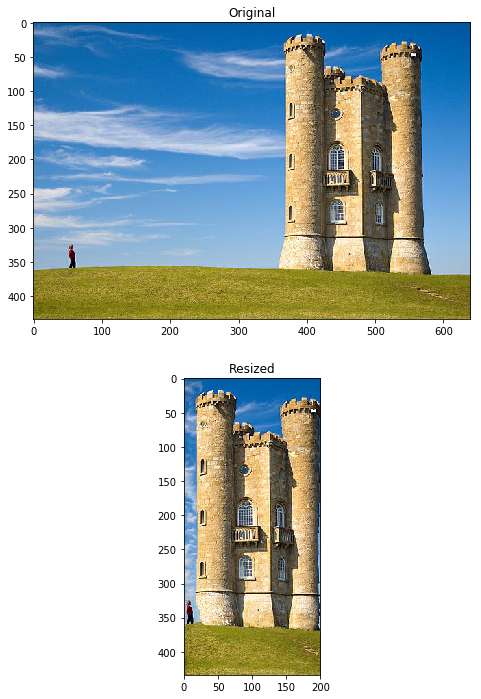

In [32]:
# Reduce image width
H, W, _ = img.shape
W_new = 200

start = time()
out = reduce(img, W_new)
end = time()

print("Reducing width from %d to %d: %f seconds." % (W, W_new, end - start))

plt.subplot(2, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(2, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.show()

## Faster `reduce` (extra credit 0.5%)

Implement a faster version of `reduce` called `reduce_fast` in the file `seam_carving.py`.

We will have a leaderboard on gradescope with the performance of students.  

The autograder tests will check that the outputs match, and run the `reduce_fast` function on a set of images with varying shapes (say between 200 and 800).

Cài đặt một phiên bản cải tiến hàm `reduce` gọi là `reduce_fast` trong file `seam_carving.py`.

In [33]:
from seam_carving import reduce_fast

# Reduce image width
H, W, _ = img.shape
W_new = 400

start = time()
out = reduce(img, W_new)
end = time()

print("Normal reduce width from %d to %d: %f seconds." % (W, W_new, end - start))

start = time()
out_fast = reduce_fast(img, W_new)
end = time()

print("Faster reduce width from %d to %d: %f seconds." % (W, W_new, end - start))

assert np.allclose(out, out_fast), "Outputs don't match."


plt.subplot(3, 1, 1)
plt.title('Original')
plt.imshow(img)

plt.subplot(3, 1, 2)
plt.title('Resized')
plt.imshow(out)

plt.subplot(3, 1, 3)
plt.title('Faster resized')
plt.imshow(out)

plt.show()

Normal reduce width from 640 to 400: 13.840576 seconds.


AssertionError: Output doesn't have the right shape

## Reducing and enlarging on another image

Also check these outputs with another image.

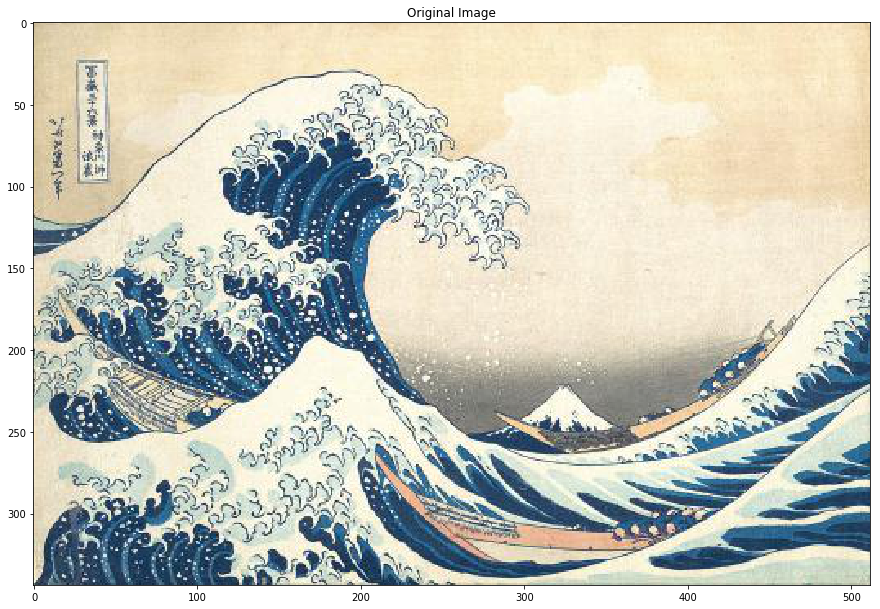

In [34]:
# Load image
img2 = io.imread('imgs/wave.jpg')
img2 = util.img_as_float(img2)

plt.title('Original Image')
plt.imshow(img2)
plt.show()

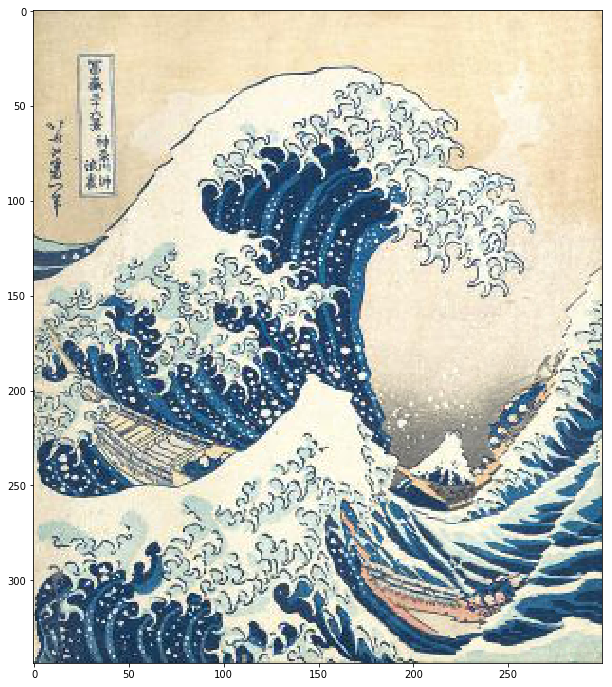

In [35]:
out = reduce(img2, 300)
plt.imshow(out)
plt.show()

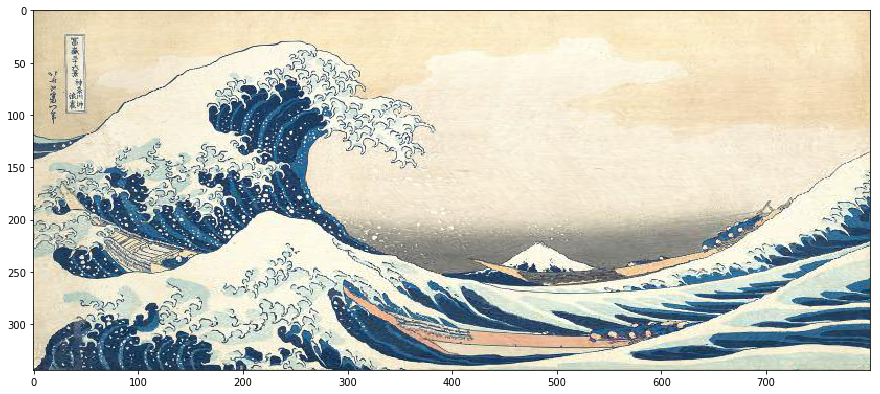

In [36]:
out = enlarge(img2, 800)
plt.imshow(out)
plt.show()

## Forward Energy (20 points)

Forward energy is a solution to some artifacts that appear when images have curves for instance.

Implement the function `compute_forward_cost`. This function will replace the `compute_cost` we have been using until now.

Forward energy (chuyển tiếp năng lượng) là một giải pháp để tránh kết quả không mong muốn trên ảnh.

Cài đặt hàm `compute_forward_cost`. Hàm này sẽ thay thế `compute_cost` ta đã sử dụng bên trên.

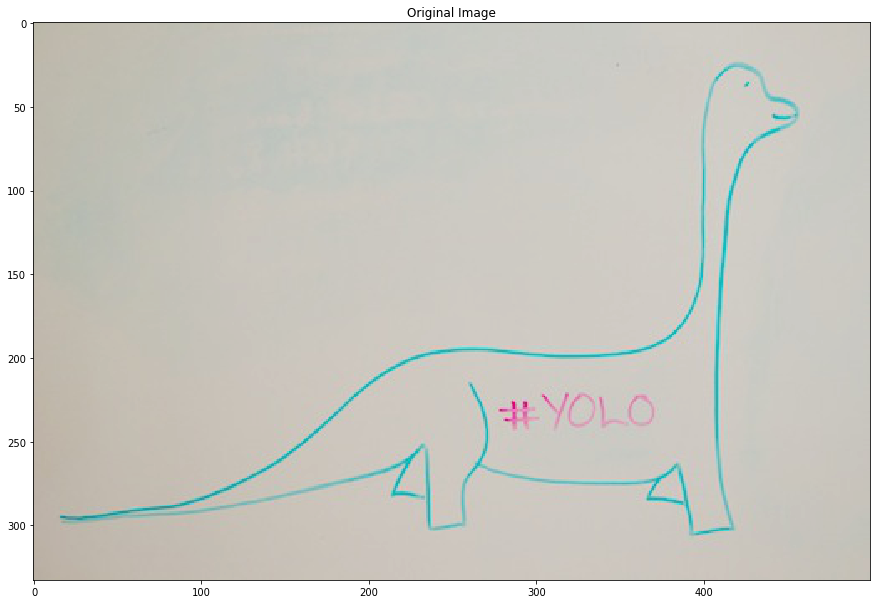

In [37]:
# Load image
img_yolo = io.imread('imgs/yolo.jpg')
img_yolo = util.img_as_float(img_yolo)

plt.title('Original Image')
plt.imshow(img_yolo)
plt.show()

In [38]:
from seam_carving import compute_forward_cost

# Let's first test with a small example
img_test = np.array([[1.0, 1.0, 2.0],
                     [0.5, 0.0, 0.0],
                     [1.0, 0.5, 2.0]])
img_test = np.stack([img_test]*3, axis=2)
assert img_test.shape == (3, 3, 3)

energy = energy_function(img_test)

solution_cost = np.array([[0.5, 2.5, 3.0],
                          [1.0, 2.0, 3.0],
                          [2.0, 4.0, 6.0]])

solution_paths = np.array([[ 0,  0,  0],
                           [ 0, -1,  0],
                           [ 0, -1, -1]])

# Vertical Cost Map
vcost, vpaths = compute_forward_cost(img_test, energy)  # don't need the first argument for compute_cost

print("Image:")
print(color.rgb2grey(img_test))

print("Energy:")
print(energy)

print("Cost:")
print(vcost)
print("Solution cost:")
print(solution_cost)

print("Paths:")
print(vpaths)
print("Solution paths:")
print(solution_paths)

assert np.allclose(solution_cost, vcost)
assert np.allclose(solution_paths, vpaths)

Image:
[[1.  1.  2. ]
 [0.5 0.  0. ]
 [1.  0.5 2. ]]
Energy:
[[0.5 1.5 3. ]
 [0.5 0.5 0. ]
 [1.  1.  3.5]]
Cost:
[[0.5 2.5 3. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
Solution cost:
[[0.5 2.5 3. ]
 [1.  2.  3. ]
 [2.  4.  6. ]]
Paths:
[[0 0 0]
 [0 0 0]
 [0 0 0]]
Solution paths:
[[ 0  0  0]
 [ 0 -1  0]
 [ 0 -1 -1]]


AssertionError: 

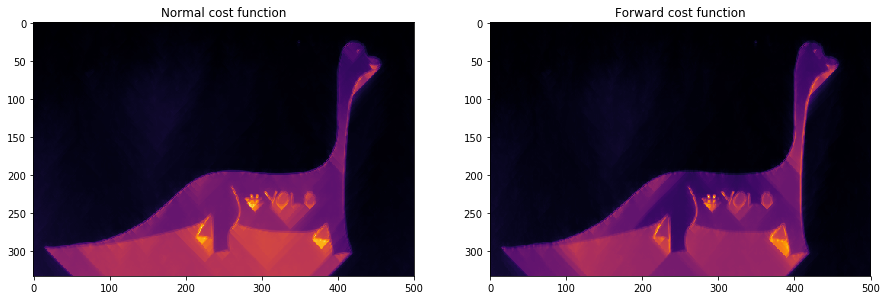

In [40]:
from seam_carving import compute_forward_cost

energy = energy_function(img_yolo)

out, _ = compute_cost(img_yolo, energy)
plt.subplot(1, 2, 1)
plt.imshow(out, cmap='inferno')
plt.title("Normal cost function")

out, _ = compute_forward_cost(img_yolo, energy)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='inferno')
plt.title("Forward cost function")

plt.show()

We observe that the forward energy insists more on the curved edges of the image.

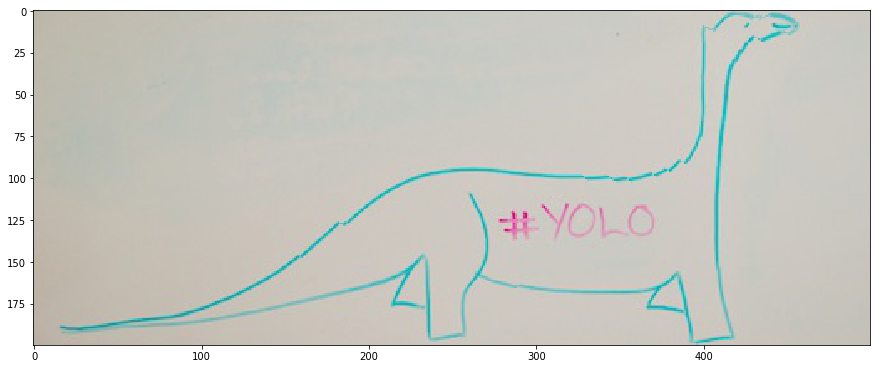

In [41]:
from seam_carving import reduce
out = reduce(img_yolo, 200, axis=0)
plt.imshow(out)
plt.show()

The issue with our standard `reduce` function is that it removes vertical seams without any concern for the energy introduced in the image.

In the case of the dinosaure above, the continuity of the shape is broken. The head is totally wrong for instance, and the back of the dinosaure lacks continuity.

**Forward energy** will solve this issue by explicitely putting high energy on a seam that breaks this continuity and introduces energy.

Vấn đề phát sinh với hàm `reduce` chuẩn là nó loại bỏ các seam dọc mà không quan tâm đến năng lượng được bổ sung vào ảnh.

Trong trường hợp ảnh khủng long bên trên, sự liên tục của hình dạng bị phá vỡ. Ví dụ, phần đầu hoàn toàn sai, phần lưng không được liên tục. 

**Forward energy** sẽ giải quyết vấn đề này bằng cách đặt năng lượng cao lên seam phá vỡ sự liên tục và bổ sung thêm năng lượng.

In [ ]:
# This step can take a very long time depending on your implementation.
out = reduce(img_yolo, 200, axis=0, cfunc=compute_forward_cost)
plt.imshow(out)
plt.show()

## Object removal (extra credit 0.5%)

Object removal uses a binary mask of the object to be removed.

Using the `reduce` and `enlarge` functions you wrote before, complete the function `remove_object` to output an image of the same shape but without the object to remove.

Loại bỏ đối tượng sử dụng mặt nạ nhị phân có hình dạng của đối tượng cần loại bỏ.

Sử dụng hai hàm `reduce` và `enlarge` đã viết, hoàn thành hàm `remove_object` để có kết quả là một ảnh có kích thước đúng kích thước ảnh ban đầu và đối tượng đã được loại bỏ.

/home/trungbanh/.local/lib/python3.6/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/home/trungbanh/.local/lib/python3.6/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/trungbanh/.local/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


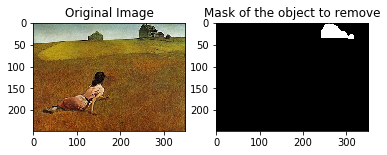

In [31]:
# Load image
image = io.imread('imgs/wyeth.jpg')
image = util.img_as_float(image)

mask = io.imread('imgs/wyeth_mask.jpg', as_grey=True)
mask = util.img_as_bool(mask)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Mask of the object to remove')
plt.imshow(mask)

plt.show()

[0 1]
(248, 350)


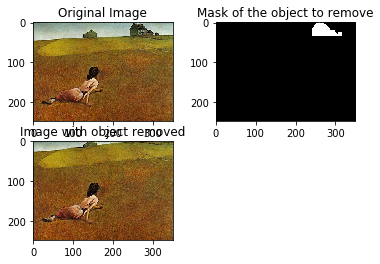

In [35]:
from seam_carving import remove_object

# Use your function to remove the object
out = remove_object(image, mask)

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image)

plt.subplot(2, 2, 2)
plt.title('Mask of the object to remove')
plt.imshow(mask)

plt.subplot(2, 2, 3)
plt.title('Image with object removed')
plt.imshow(out)

plt.show()